In [1]:
!nvidia-smi

Mon May 24 01:10:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
!wget https://raw.githubusercontent.com/jiaweichang/biography/master/slides/10902/%E5%B0%96%E5%85%B5/L8/Opinion%20Mining/gossip.json

--2021-05-24 02:04:13--  https://raw.githubusercontent.com/jiaweichang/biography/master/slides/10902/%E5%B0%96%E5%85%B5/L8/Opinion%20Mining/gossip.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27130380 (26M) [text/plain]
Saving to: ‘gossip.json.1’

gossip.json.1       100%[===================>]  25.87M  78.8MB/s    in 0.3s    

2021-05-24 02:04:14 (78.8 MB/s) - ‘gossip.json.1’ saved [27130380/27130380]



In [14]:
!wget https://github.com/jiaweichang/biography/raw/master/slides/10902/尖兵/L8/Opinion%20Mining/DejaVuSans.ttf

--2021-05-24 02:05:26--  https://github.com/jiaweichang/biography/raw/master/slides/10902/%E5%B0%96%E5%85%B5/L8/Opinion%20Mining/DejaVuSans.ttf
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jiaweichang/biography/master/slides/10902/%E5%B0%96%E5%85%B5/L8/Opinion%20Mining/DejaVuSans.ttf [following]
--2021-05-24 02:05:27--  https://raw.githubusercontent.com/jiaweichang/biography/master/slides/10902/%E5%B0%96%E5%85%B5/L8/Opinion%20Mining/DejaVuSans.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21663376 (21M) [application/octet-stream]
Saving to: ‘DejaVuSans.ttf’

DejaVuSans.ttf      100%

In [3]:
#coding=utf-8 
import json  #用來讀取/產生 json 格式的套件
import jieba #用來處理中文斷詞的套件
import numpy as np #用來處理數值矩陣的套件

import matplotlib as mpl #用來繪製圖表的套件
import matplotlib.pyplot as plt #為 matplotlib 的子套件，提供命令行式函數的集合
import seaborn as sns #基礎於 matplotlib 的高階圖表的繪製套件


'''sklearn 又名 scikit-learn，為機器學習方法的套件'''

from sklearn.feature_extraction import DictVectorizer #用於轉換 dict 為 sklearn estimators 可用的向量
from sklearn.feature_extraction.text import TfidfTransformer #將矩陣轉換為 TF 或 TF-IDF 表示
from sklearn.svm import LinearSVC #以 LinearSVC 分類演算法為例

from collections import defaultdict #使用 dict 儲存資料

zhfont1 = mpl.font_manager.FontProperties(fname='Chinese.ttf') #讀取中文字型

In [4]:
# load ptt posts

path = 'gossip.json' # 欲載入文檔之路徑

with open(path, encoding='utf8') as f:
    posts = json.load(f)

In [5]:

# get pushes

total_comments = defaultdict(int)
total_pushes = defaultdict(int)
total_hates = defaultdict(int)

for post in posts:
    for comment in post['comments']:
        user = comment['user']
        total_comments[user] += 1

        if comment['score'] > 0:
            total_pushes[user] += 1
        elif comment['score'] < 0:
            total_hates[user] += 1

In [6]:
def show_distributions(counts, pushes, hates):
    sorted_cnts = [t[0] for t in sorted(counts.items(), key=lambda x: -x[1])][:20] #取前20個最踴躍回覆者之數據
    usernames = [u for u in sorted_cnts]
    total_y = [counts[u] for u in sorted_cnts]
    y_pushes = [pushes[u] for u in sorted_cnts]
    y_hates = [hates[u] for u in sorted_cnts]
    y_neutral = np.asarray(total_y) - np.asarray(y_pushes) - np.asarray(y_hates) #取得箭頭(中立)之留言數
    y_NandP = y_neutral + np.asarray(y_pushes)

    X = np.arange(20)
    fig, ax = plt.subplots(figsize=(10,8))

    plt.bar(X, np.asarray(y_pushes)+np.asarray(y_neutral), facecolor='#00ACC1', edgecolor='white')
    plt.bar(X, np.asarray(y_neutral), facecolor='#7CB342', edgecolor='white')
    plt.bar(X, -np.asarray(y_hates), facecolor='#FFB300', edgecolor='white')
    plt.xlim(-0.5, 19.5)

    ax.set_xticks(X)
    ax.set_xticklabels(usernames, rotation=45, fontsize=10, fontdict={'fontname': 'DejaVu Sans', 'fontsize':10})
    plt.ylim(-max(y_hates)*1.2, max(y_NandP)*1.2)
    plt.yticks(())
    
    for x,y,z in zip(X, np.asarray(y_pushes)+np.asarray(y_neutral), np.asarray(y_pushes)):
        plt.text(x, y+10, z, ha='center', va='bottom')

    for x,y in zip(X, np.asarray(y_neutral)):
        plt.text(x, y-35, y, ha='center', va='bottom')

    for x,y in zip(X, -np.asarray(y_hates)):
        plt.text(x, y-35, abs(y), ha='center', va='bottom')
    
    plt.show(fig)

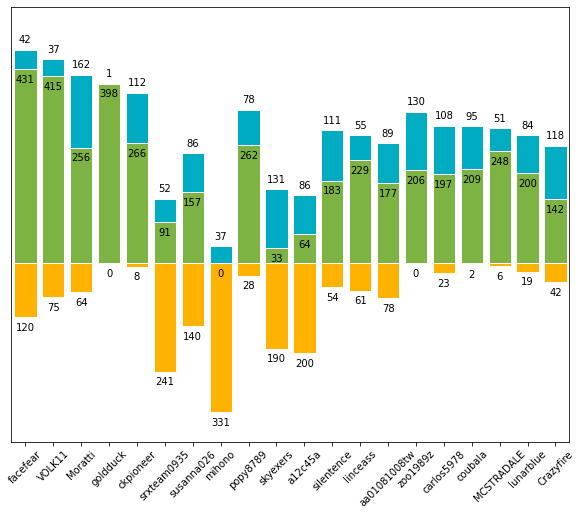

In [7]:
# display the distributions of top 20 users' comments
show_distributions(total_comments, total_pushes, total_hates)

In [8]:
# grap comments

c_words = []
c_scores = []

for post in posts:
    for comment in post['comments']: #取得八卦文文章之鄉民留言
        l = comment['content'].strip() #去頭去尾換行之類的字符
        if l and comment['score'] != 0:
            d = defaultdict(int)
            for w in jieba.cut(l): # w 是針對 l 中的文字斷詞後所得之詞語
                d[w] += 1
            if len(d) > 0:
                c_scores.append(1 if comment['score'] > 0 else 0) #每一則留言之標記(推/噓)
                c_words.append(d)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.795 seconds.
Prefix dict has been built successfully.


In [9]:
# convert to vectors
c_dvec = DictVectorizer()
c_tfidf = TfidfTransformer()
c_vector = c_dvec.fit_transform(c_words)
c_X = c_tfidf.fit_transform(c_vector) #將一千篇所有鄉民留言的斷詞文字矩陣轉成向量並計算tf-idf

In [10]:
# build and train the classifier
c_svc = LinearSVC()
c_svc.fit(c_X, c_scores)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [11]:
#分類留言的情緒
def comment_sentiment_classifier(model, dvec, tfidf, text):
    l = text.strip() #去頭去尾換行之類的字符
    d = defaultdict(int)

    for w in jieba.cut(l): # w 是針對 l 中的文字斷詞後所得之詞語
        d[w] += 1

    comment_vec = dvec.transform(d)
    comment_X = tfidf.transform(comment_vec)
    result = model.predict(comment_X)
    
    if result == 1:
        print(text,'---感覺還不錯哦！')
    else:
        print(text,'---你很不開心喔？')

In [12]:
while (1):
    s = input('輸入留言！偵測你的情緒狀態：')
    if s == '-1':
        print('掰掰！歡迎再來玩！')
        break
    else:
        comment_sentiment_classifier(c_svc, c_dvec, c_tfidf, s)

輸入留言！偵測你的情緒狀態：罪有英德
罪有英德 ---你很不開心喔？
輸入留言！偵測你的情緒狀態：-1
掰掰！歡迎再來玩！
